In [1]:
import sys
from IPython.display import SVG

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from rdkit import rdBase
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from rdkit.Chem.Draw import DrawMorganBit, DrawMorganBits,DrawMorganEnv, IPythonConsole
from rdkit.Chem import MACCSkeys

import tensorflow as tf
import keras as kr
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

from sklearn.preprocessing import StandardScaler
from sklearn import model_selection

%matplotlib inline

In [2]:
fp_para = pd.read_csv('../data/substituted_benzene_para_fp.csv')
#fp_mono = pd.read_csv('../data/substituted_benzene_mono_fp.csv')
fp_orth = pd.read_csv('../data/substituted_benzene_orth_fp.csv')
fp_meta = pd.read_csv('../data/substituted_benzene_meta_fp.csv')
fp = pd.concat([fp_meta,fp_orth,fp_para],axis=0,join='inner',ignore_index=True)

In [3]:
#gammadata_mono = pd.read_csv('../data/substituted_benzene_mono_gamma.csv')
gammadata_meta = pd.read_csv('../data/substituted_benzene_meta_gamma.csv')
gammadata_orth = pd.read_csv('../data/substituted_benzene_orth_gamma.csv')
gammadata_para = pd.read_csv('../data/substituted_benzene_para_gamma.csv')
gammadata = pd.concat([gammadata_meta,gammadata_orth,gammadata_para],axis=0,join='inner',ignore_index=True)

In [4]:
result = pd.merge(fp, gammadata, on='cindex')
#result = result.sort_values(by='gamma', ascending=False)

In [5]:
Y = result.iloc[:, -1]
Y = np.array(Y, dtype = np.float32)
Y=Y/45000

X = result.iloc[:, 2:-4]
X = X[X.T[X.dtypes!=np.object].index]
X = np.array(X, dtype = np.float32)
st = StandardScaler()
X= st.fit_transform(X)

In [6]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.25, random_state=42)
model = Sequential()
#输入层。传递给下一层的维度为50。 输入数据维度（input_dim）是1114。
model.add(Dense(units = 50, input_dim = X.shape[1]))
#model.add(Activation("relu"))
model.add(Activation("sigmoid"))
model.add(tf.keras.layers.Dropout(0.2))

#输出层。 维度1，即输出单个值。
model.add(Dense(units = 1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                8350      
_________________________________________________________________
activation (Activation)      (None, 50)                0         
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 8,401
Trainable params: 8,401
Non-trainable params: 0
_________________________________________________________________


In [7]:
#SGD是随机梯度下降法。 nesterov是Nesterov的加速度梯度下降法。
model.compile(loss = 'mean_squared_error', optimizer = SGD(lr = 0.001, momentum = 0.9, nesterov = True),metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs = 300, batch_size = 32,validation_data = (X_test, y_test),verbose=0)
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
y_pred = model.predict(X_test)
rms = (np.mean((y_test - y_pred) ** 2)) ** 0.5
#s = np.std(y_test - y_pred)
print("Neural Network RMS", rms)

Test loss: 0.012864426709711552
Test accuracy: 0.0
Neural Network RMS 0.12871489627289823


<Figure size 432x288 with 0 Axes>

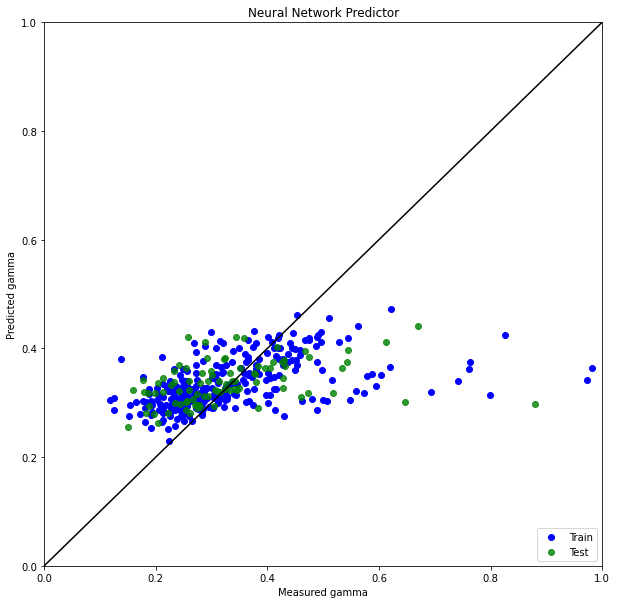

In [8]:
plt.figure()
plt.figure(figsize=(10,10))
plt.scatter(y_train, model.predict(X_train), label = 'Train', c = 'blue')
plt.title('Neural Network Predictor')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Measured gamma')
plt.ylabel('Predicted gamma')
plt.scatter(y_test, model.predict(X_test), c = 'green', label = 'Test', alpha = 0.8)
plt.plot([0,1],[0,1],c = 'k')
plt.legend(loc = 4)
#plt.savefig('Neural Network Predictor.png', dpi=500)
plt.show()

the divergence of the test set can not be ignore

still over-fitting

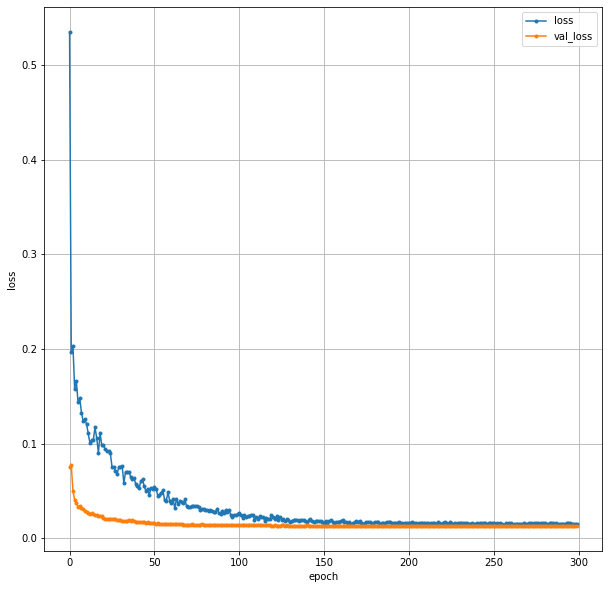

In [9]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = len(loss)
plt.figure(figsize=(10,10))
plt.plot(range(epochs), loss, marker = '.', label = 'loss')
plt.plot(range(epochs), val_loss, marker = '.', label = 'val_loss')
plt.legend(loc = 'best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.savefig('loss & val_loss for epochs.png', dpi=500)
plt.show()

still can't better than 'sigmoid', 